In [49]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from datetime import datetime

In [62]:
import numpy.ma as ma
from scipy.stats.stats import pearsonr, normaltest
from scipy.spatial.distance import correlation

In [3]:
def confusion_matrix_train(model,cutoff=0.5):
    # Confusion matrix
    cm_df = pd.DataFrame(model.pred_table(threshold = cutoff))
    #Formatting the confusion matrix
    cm_df.columns = ['Predicted 0', 'Predicted 1'] 
    cm_df = cm_df.rename(index={0: 'Actual 0',1: 'Actual 1'})
    cm = np.array(cm_df)
    # Calculate the accuracy
    accuracy = (cm[0,0]+cm[1,1])/cm.sum()
    sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
    plt.ylabel("Actual Values")
    plt.xlabel("Predicted Values")
    print("Classification accuracy = {:.1%}".format(accuracy))

## AUTOCORRELATION

In [82]:
# A few helper functions
import statsmodels.api as sm
import numpy.ma as ma
from scipy.stats.stats import pearsonr, normaltest
from scipy.spatial.distance import correlation
def build_model(features):
  X=sm.add_constant(rides_input[features])
  y=rides_input['price']
  model = sm.OLS(y,X, missing='drop').fit()
  predictions = model.predict(X) 
  display(model.summary()) 
  res=y-predictions
  return res 


def plt_residual(res):
  plt.plot(range(len(res)), res) 
  plt.ylabel('Residual')
  plt.xlabel("Hour")

def plt_residual_lag(res, nlag):
  x=res.values
  y=res.shift(nlag).values
  sns.kdeplot(x,y=y,color='blue',shade=True )
  plt.xlabel('res')
  plt.ylabel("res-lag-{}".format(nlag))
  rho,p=corrcoef(x,y)
  plt.title("n_lag={} hours, correlation={:f}".format(nlag, rho))
  
def plt_acf(res):
  plt.rcParams['figure.figsize'] = [18, 5]
  acorr = sm.tsa.acf(res.dropna(), nlags = len(res.dropna())-1)
  fig, (ax1) = plt.subplots(1)
  ax1.plot(acorr)
  ax1.set_ylabel('corr')
  ax1.set_xlabel('n_lag')
  ax1.set_title('Auto Correlation')
  plt.show()
  pd.set_option('display.max_columns', None)
  adf=pd.DataFrame(np.round(acorr[:30*24],2).reshape([30, 24] ))
  adf.index.name='day'
  display(adf)
  plt.rcParams['figure.figsize'] = [9, 5]

def corrcoef(x,y):
    a,b=ma.masked_invalid(x),ma.masked_invalid(y)
    msk = (~a.mask & ~b.mask)
    return pearsonr(x[msk],y[msk])[0], normaltest(res, nan_policy='omit')[1]

In [51]:
weather = pd.read_csv('weather.csv')
rides = pd.read_csv('cab_rides.csv')

In [52]:
rides['time'] = pd.to_datetime(rides['time_stamp'], unit = 'ms')
rides['date_hour'] = rides['time'].dt.strftime('%Y-%m-%d:%H.%M.%S')
weather['time'] = pd.to_datetime(weather['time_stamp'], unit = 's')
weather['date_hour'] = weather['time'].dt.strftime('%Y-%m-%d:%H.%M.%S')
    
rides = rides.drop('time_stamp', axis = 1)
weather = weather.drop('time_stamp', axis = 1)

rides['timestamp'] = rides.date_hour.apply(lambda x: (datetime.strptime(x,'%Y-%m-%d:%H.%M.%S')))

#Find hour of each trip
rides['hour'] = rides['timestamp'].dt.strftime('%H')

#Find date of each trip
rides['date'] = rides['timestamp'].dt.strftime('%Y-%m-%d') 

#Find day name of each trip
rides['day'] = rides['timestamp'].dt.day_name()

# drop redundant fields 
rides = rides.drop('timestamp', axis=1)

In [70]:
rides.sort_values(by='time', inplace = True)
rides_new = rides.reset_index()
rides_new["ride_count"] = 1
rides_new

,index,distance,cab_type,destination,source,price,surge_multiplier,id,product_id,name,time,date_hour,hour,date,day,ride_count
0,30792,3.03,Lyft,Theatre District,Boston University,34.0,1.0,ef4771c2-c88d-4730-aaf7-a95751e9d27e,lyft_luxsuv,Lux Black XL,2018-11-26 03:40:46.318,2018-11-26:03.40.46,03,2018-11-26,Monday,1
1,446073,1.57,Uber,North End,Theatre District,NaN,1.0,9962f244-8fce-4ae9-a583-139d5d7522e1,8cf7e821-f0d3-49c6-8eba-e679c0ebcf6a,Taxi,2018-11-26 03:40:46.319,2018-11-26:03.40.46,03,2018-11-26,Monday,1
2,65662,1.30,Uber,Theatre District,South Station,18.5,1.0,00ea74ea-2c49-416c-bfc5-f7877025f6eb,6c84fd89-3f11-4782-9b50-97c468b19529,Black,2018-11-26 03:40:46.319,2018-11-26:03.40.46,03,2018-11-26,Monday,1
3,613927,2.71,Uber,Fenway,Theatre District,19.5,1.0,8682f9bf-5cc0-4dfc-b8fe-4e22070d1684,55c66225-fbe7-4fd5-9072-eab1ece5e23e,UberX,2018-11-26 03:40:46.320,2018-11-26:03.40.46,03,2018-11-26,Monday,1
4,98705,2.43,Lyft,Beacon Hill,Northeastern University,10.5,1.0,edfc7f44-97e1-48cd-930c-e4fe20e88ac8,lyft,Lyft,2018-11-26 03:40:46.320,2018-11-26:03.40.46,03,2018-11-26,Monday,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
693066,205380,2.40,Lyft,Beacon Hill,Northeastern University,10.5,1.0,12b81ef2-422b-4a39-9ef7-701c0f197cea,lyft,Lyft,2018-12-18 19:15:10.943,2018-12-18:19.15.10,19,2018-12-18,Tuesday,1
693067,18039,2.48,Uber,South Station,Beacon Hill,14.0,1.0,e7ff1618-2d8b-4d13-a798-593858064a9e,6f72dfc5-27f1-42e8-84db-ccc7a75f6969,UberXL,2018-12-18 19:15:10.943,2018-12-18:19.15.10,19,2018-12-18,Tuesday,1
693068,205381,2.40,Lyft,Beacon Hill,Northeastern University,7.0,1.0,24712695-5b52-4886-955f-39c4bcd7c200,lyft_line,Shared,2018-12-18 19:15:10.943,2018-12-18:19.15.10,19,2018-12-18,Tuesday,1
693069,205383,2.40,Lyft,Beacon Hill,Northeastern University,16.5,1.0,b6710feb-4586-4c61-a2cf-cd4025ae8587,lyft_plus,Lyft XL,2018-12-18 19:15:10.943,2018-12-18:19.15.10,19,2018-12-18,Tuesday,1


In [78]:
rides_auto = rides_new[["price", "hour", "date", "ride_count"]]
rides_auto.dropna(axis = 0, inplace = True)
rides_auto = rides_auto.groupby(by=["date", "hour"]).agg({'price': 'mean', 'ride_count': 'sum'})
rides_input = rides_auto.reset_index()
rides_input['ride_count']=rides_input['ride_count'].shift(24*1)
rides_input.tail()

/var/folders/j0/zm8bptz11xb8ssm1_bd36s6r0000gn/T/ipykernel_8742/733382154.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rides_auto.dropna(axis = 0, inplace = True)


,date,hour,price,ride_count
327,2018-12-18,15,16.142188,1706.0
328,2018-12-18,16,16.618575,1730.0
329,2018-12-18,17,16.565129,1733.0
330,2018-12-18,18,16.865330,1726.0
331,2018-12-18,19,16.555651,1719.0


In [79]:
res=build_model(["ride_count"])

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                      -0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Wed, 15 Mar 2023   Prob (F-statistic):                nan
Time:                        13:48:34   Log-Likelihood:            -2.3296e+06
No. Observations:              637976   AIC:                         4.659e+06
Df Residuals:                  637975   BIC:                         4.659e+06
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
ride_count    16.5451      0.012   1417.272      0.000      16.522      16.568
==============================================================================
Omnibus:                    96869.345   Durbin-Watson:                   1.979
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           156157.577
Skew:                           1.046   Prob(JB):                         0.00
Kurtosis:                       4.225   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

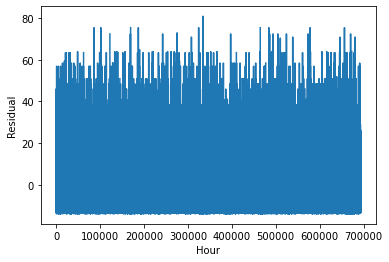

In [80]:
plt_residual(res)  

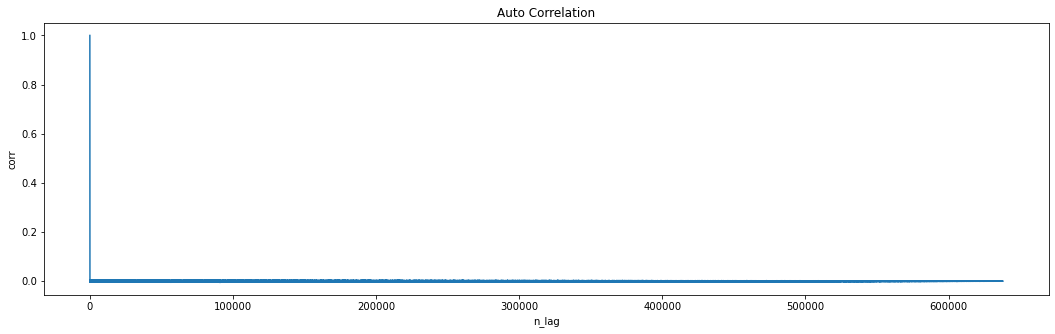

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
day,,,,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.01,0.01,0.0,0.01,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,0.0,0.0
1,-0.0,0.00,-0.00,0.0,0.00,0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0
2,-0.0,0.00,-0.00,-0.0,0.00,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,0.0,-0.0,-0.0,0.0,0.0,0.0,0.0
3,0.0,0.00,-0.00,-0.0,0.00,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0
4,-0.0,0.00,0.00,0.0,-0.00,0.0,-0.0,0.0,0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,0.0,-0.0,0.0,-0.0,0.0,0.0
5,-0.0,-0.00,-0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,-0.0,0.0,0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0
6,-0.0,0.00,0.00,0.0,0.00,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,0.0
7,0.0,-0.00,0.00,-0.0,0.00,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,0.0,-0.0,-0.0,-0.0,0.0,-0.0,0.0
8,0.0,-0.00,0.00,0.0,0.00,-0.0,-0.0,0.0,-0.0,0.0,-0.0,0.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,0.0,-0.0,-0.0


In [83]:
plt_acf(res)

In [4]:
rides.isnull().sum()

distance                0
cab_type                0
time_stamp              0
destination             0
source                  0
price               55095
surge_multiplier        0
id                      0
product_id              0
name                    0
dtype: int64

In [31]:
rides.dropna(axis = 0, inplace = True)

In [8]:
weather.isnull().sum()

temp             0
location         0
clouds           0
pressure         0
rain          5382
time_stamp       0
humidity         0
wind             0
dtype: int64

In [32]:
weather.fillna(0, inplace = True)

In [36]:
weather_avg = weather.groupby('location').mean().reset_index()
weather_avg.drop(columns = 'time_stamp' , inplace = True)
weather_source = weather_avg.rename(columns =(lambda x :x + '_source'))       
weather_source.rename(columns= {'location_source' :'source'}, inplace = True)
weather_destination = weather_avg.rename(columns =(lambda x :x+'_destination'))       
weather_destination.rename(columns= {'location_destination' :'destination'} ,inplace = True)
data = rides\
       .merge(weather_source ,on ='source')\
       .merge(weather_destination ,on = 'destination')

#binary encoding to cab_type

data['cab_type'] =data['cab_type'].replace({'Uber':1,'Lyft':0})

def one_hot_encode(df , column , prefix):
    dummy = pd.get_dummies(df[column] ,prefix = prefix)
    df = pd.concat([df , dummy] ,axis =1)
    df =df.drop(column , axis =1)
    
    return df

#data = one_hot_encode(data ,column =  'destination' , prefix = 'desti')
#data = one_hot_encode(data ,column =  'source' , prefix = 'src')
#data = one_hot_encode(data ,column =  'product_id' , prefix = 'pid')
#data = one_hot_encode(data ,column =  'name' , prefix = 'nm')

In [37]:
data.head()

,distance,cab_type,time_stamp,destination,source,price,surge_multiplier,id,product_id,name,...,pressure_source,rain_source,humidity_source,wind_source,temp_destination,clouds_destination,pressure_destination,rain_destination,humidity_destination,wind_destination
0,0.44,0,1544952607890,North Station,Haymarket Square,5.0,1.0,424553bb-7174-41ea-aeb4-fe06d4f4b9d7,lyft_line,Shared,...,1008.445239,0.00866,0.764837,6.843193,39.035315,0.676998,1008.442811,0.008649,0.765545,6.835755
1,0.44,0,1543284023677,North Station,Haymarket Square,11.0,1.0,4bd23055-6827-41c6-b23b-3c491f24e74d,lyft_premier,Lux,...,1008.445239,0.00866,0.764837,6.843193,39.035315,0.676998,1008.442811,0.008649,0.765545,6.835755
2,0.44,0,1543366822198,North Station,Haymarket Square,7.0,1.0,981a3613-77af-4620-a42a-0c0866077d1e,lyft,Lyft,...,1008.445239,0.00866,0.764837,6.843193,39.035315,0.676998,1008.442811,0.008649,0.765545,6.835755
3,0.44,0,1543553582749,North Station,Haymarket Square,26.0,1.0,c2d88af2-d278-4bfd-a8d0-29ca77cc5512,lyft_luxsuv,Lux Black XL,...,1008.445239,0.00866,0.764837,6.843193,39.035315,0.676998,1008.442811,0.008649,0.765545,6.835755
4,0.44,0,1543463360223,North Station,Haymarket Square,9.0,1.0,e0126e1f-8ca9-4f2e-82b3-50505a09db9a,lyft_plus,Lyft XL,...,1008.445239,0.00866,0.764837,6.843193,39.035315,0.676998,1008.442811,0.008649,0.765545,6.835755


In [8]:
train, test = train_test_split(data, test_size = 0.3)

In [9]:
def dummy(row):
    if row["surge_multiplier"] == 1:
        return 0
    return 1

In [9]:
import os  
os.makedirs('folder/subfolder', exist_ok = True)  
train.to_csv('folder/subfolder/train_final_project.csv') 
test.to_csv('folder/subfolder/test_final_project.csv') 

In [10]:
id_list_train = list(train['id'])
rides['bool'] = rides['id'].isin(id_list_train)
train_original = rides.loc[rides['bool'], :]

id_list_test = list(test['id'])
rides['bool'] = rides['id'].isin(id_list_test)
test_original = rides.loc[rides['bool'], :]

In [11]:
train_original["surge_dummy"] = train_original.apply(lambda x: dummy(x), axis = 1)
train_original.head()

/var/folders/j0/zm8bptz11xb8ssm1_bd36s6r0000gn/T/ipykernel_18387/1842354095.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_original["surge_dummy"] = train_original.apply(lambda x: dummy(x), axis = 1)


,distance,cab_type,time_stamp,destination,source,price,surge_multiplier,id,product_id,name,bool,surge_dummy
1,0.44,Lyft,1543284023677,North Station,Haymarket Square,11.0,1.0,4bd23055-6827-41c6-b23b-3c491f24e74d,lyft_premier,Lux,True,0
2,0.44,Lyft,1543366822198,North Station,Haymarket Square,7.0,1.0,981a3613-77af-4620-a42a-0c0866077d1e,lyft,Lyft,True,0
3,0.44,Lyft,1543553582749,North Station,Haymarket Square,26.0,1.0,c2d88af2-d278-4bfd-a8d0-29ca77cc5512,lyft_luxsuv,Lux Black XL,True,0
7,1.08,Lyft,1543780384677,Northeastern University,Back Bay,16.5,1.0,474d6376-bc59-4ec9-bf57-4e6d6faeb165,lyft_lux,Lux Black,True,0
8,1.08,Lyft,1543818482645,Northeastern University,Back Bay,3.0,1.0,4f9fee41-fde3-4767-bbf1-a00e108701fb,lyft_line,Shared,True,0


In [15]:
ols_object_basic_log = smf.logit(formula = 'surge_dummy~time_stamp', data = train_original)
model_basic_log = ols_object_basic_log.fit()
model_basic_log.summary()

Optimization terminated successfully.
         Current function value: 0.144693
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            surge_dummy   No. Observations:               446583
Model:                          Logit   Df Residuals:                   446581
Method:                           MLE   Df Model:                            1
Date:                Mon, 06 Mar 2023   Pseudo R-squ.:               3.332e-06
Time:                        13:21:16   Log-Likelihood:                -64617.
converged:                       True   LL-Null:                       -64618.
Covariance Type:            nonrobust   LLR p-value:                    0.5117
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -15.7038     18.772     -0.837      0.403     -52.496      21.088
time_stamp  7.981e-12   1.22e-11      0.656      0.512   -1.58e-11    3.18e-11
==============================================================================
"""

Classification accuracy = 96.7%


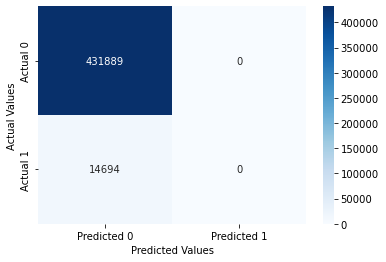

In [16]:
cm = confusion_matrix_train(model_basic_log)

In [12]:
ols_object_basic = smf.ols(formula = 'price~distance+cab_type+time_stamp+destination+source+surge_multiplier+product_id+name', data = train_original)
model_basic = ols_object_basic.fit()
model_basic.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.929
Model:                            OLS   Adj. R-squared:                  0.929
Method:                 Least Squares   F-statistic:                 1.710e+05
Date:                Mon, 06 Mar 2023   Prob (F-statistic):               0.00
Time:                        15:48:52   Log-Likelihood:            -1.0418e+06
No. Observations:              446583   AIC:                         2.084e+06
Df Residuals:                  446548   BIC:                         2.084e+06
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
======================================================================================================================
                                                         coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------
Intercept                                             -0.0022   3.06e-05    -70.319      0.000      -0.002      -0.002
cab_type[T.Uber]                                      -0.7296      0.005   -148.191      0.000      -0.739      -0.720
destination[T.Beacon Hill]                            -0.3123      0.018    -17.057      0.000      -0.348      -0.276
destination[T.Boston University]                      -0.0528      0.015     -3.442      0.001      -0.083      -0.023
destination[T.Fenway]                                 -0.3765      0.015    -24.794      0.000      -0.406      -0.347
destination[T.Financial District]                      0.4130      0.018     22.516      0.000       0.377       0.449
destination[T.Haymarket Square]                        0.1707      0.015     11.069      0.000       0.140       0.201
destination[T.North End]                               0.0294      0.015      1.949      0.051      -0.000       0.059
destination[T.North Station]                           0.1995      0.018     10.859      0.000       0.163       0.235
destination[T.Northeastern University]                -0.0390      0.015     -2.596      0.009      -0.068      -0.010
destination[T.South Station]                          -0.0706      0.015     -4.647      0.000      -0.100      -0.041
destination[T.Theatre District]                        0.2381      0.018     13.014      0.000       0.202       0.274
destination[T.West End]                               -0.0523      0.018     -2.858      0.004      -0.088      -0.016
source[T.Beacon Hill]                                 -0.3208      0.018    -17.533      0.000      -0.357      -0.285
source[T.Boston University]                           -0.2937      0.015    -19.033      0.000      -0.324      -0.263
source[T.Fenway]                                      -0.0966      0.015     -6.357      0.000      -0.126      -0.067
source[T.Financial District]                           0.3381      0.018     18.311      0.000       0.302       0.374
source[T.Haymarket Square]                             0.3640      0.016     23.322      0.000       0.333       0.395
source[T.North End]                                    0.5268      0.015     34.921      0.000       0.497       0.556
source[T.North Station]                                0.0560      0.018      3.046      0.002       0.020       0.092
source[T.Northeastern University]                     -0.3226      0.015    -21.287      0.000      -0.352      -0.293
source[T.South Station]                                0.1684      0.015     11.215      0.000       0.139       0.198
source[T.Theatre District]                             0.5148      0.018     28.179      0.000       0.479  

In [13]:
np.sqrt(((test_original.price - model_basic.predict(test_original))**2).mean())

2.4858536810257728

In [14]:
np.sqrt(model_basic.mse_resid)

2.4938985738768924

In [15]:
train_orig_reset = train_original.reset_index()
train_orig_reset.head()

,index,distance,cab_type,time_stamp,destination,source,price,surge_multiplier,id,product_id,name,bool,surge_dummy
0,1,0.44,Lyft,1543284023677,North Station,Haymarket Square,11.0,1.0,4bd23055-6827-41c6-b23b-3c491f24e74d,lyft_premier,Lux,True,0
1,2,0.44,Lyft,1543366822198,North Station,Haymarket Square,7.0,1.0,981a3613-77af-4620-a42a-0c0866077d1e,lyft,Lyft,True,0
2,3,0.44,Lyft,1543553582749,North Station,Haymarket Square,26.0,1.0,c2d88af2-d278-4bfd-a8d0-29ca77cc5512,lyft_luxsuv,Lux Black XL,True,0
3,7,1.08,Lyft,1543780384677,Northeastern University,Back Bay,16.5,1.0,474d6376-bc59-4ec9-bf57-4e6d6faeb165,lyft_lux,Lux Black,True,0
4,8,1.08,Lyft,1543818482645,Northeastern University,Back Bay,3.0,1.0,4f9fee41-fde3-4767-bbf1-a00e108701fb,lyft_line,Shared,True,0


In [16]:
ols_object_basic2 = smf.ols(formula = 'price~distance+cab_type+time_stamp+destination+source+surge_multiplier+product_id+name', data = train_orig_reset)
model_basic2 = ols_object_basic2.fit()

In [17]:
#take a look at high leverage points
influence = model_basic2.get_influence()
leverage = influence.hat_matrix_diag
#obtain standardized residuals
standardized_residuals = influence.resid_studentized_internal

In [18]:
standardized_residuals

array([-0.61052735,  1.07672343, -0.43147639, ..., -0.87913713,
        1.27585548,  1.88399542])

In [19]:
#calculate number of high leverage points
average_leverage = (model_basic2.df_model+1)/model_basic2.nobs

high_leverage_threshold = 4*average_leverage

np.sum(leverage>high_leverage_threshold)

584

In [82]:
#np.intersect1d(np.where(np.abs(standardized_residuals)>3)[0],
                                           #(np.where(leverage>high_leverage_threshold)[0]))

In [20]:
#remove high leverage
train_orig_reset_filt = train_orig_reset.drop(np.intersect1d(np.where(np.abs(standardized_residuals)>3)[0],
                                           (np.where(leverage>high_leverage_threshold)[0])))


In [21]:
ols_object_basic3 = smf.ols(formula = 'price~distance+cab_type+time_stamp+destination+source+surge_multiplier+product_id+name', data = train_orig_reset_filt)
model_basic3 = ols_object_basic3.fit()
model_basic3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.930
Model:                            OLS   Adj. R-squared:                  0.930
Method:                 Least Squares   F-statistic:                 1.739e+05
Date:                Mon, 06 Mar 2023   Prob (F-statistic):               0.00
Time:                        15:49:21   Log-Likelihood:            -1.0363e+06
No. Observations:              446277   AIC:                         2.073e+06
Df Residuals:                  446242   BIC:                         2.073e+06
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
======================================================================================================================
                                                         coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------
Intercept                                             -0.0012   3.03e-05    -38.349      0.000      -0.001      -0.001
cab_type[T.Uber]                                      -0.7236      0.005   -148.505      0.000      -0.733      -0.714
destination[T.Beacon Hill]                            -0.3191      0.018    -17.610      0.000      -0.355      -0.284
destination[T.Boston University]                      -0.0571      0.015     -3.760      0.000      -0.087      -0.027
destination[T.Fenway]                                 -0.3766      0.015    -25.052      0.000      -0.406      -0.347
destination[T.Financial District]                      0.4102      0.018     22.587      0.000       0.375       0.446
destination[T.Haymarket Square]                        0.1661      0.015     10.879      0.000       0.136       0.196
destination[T.North End]                               0.0257      0.015      1.723      0.085      -0.004       0.055
destination[T.North Station]                           0.1930      0.018     10.617      0.000       0.157       0.229
destination[T.Northeastern University]                -0.0292      0.015     -1.963      0.050      -0.058   -4.59e-05
destination[T.South Station]                          -0.0735      0.015     -4.888      0.000      -0.103      -0.044
destination[T.Theatre District]                        0.2306      0.018     12.733      0.000       0.195       0.266
destination[T.West End]                               -0.0587      0.018     -3.238      0.001      -0.094      -0.023
source[T.Beacon Hill]                                 -0.3278      0.018    -18.108      0.000      -0.363      -0.292
source[T.Boston University]                           -0.2909      0.015    -19.047      0.000      -0.321      -0.261
source[T.Fenway]                                      -0.0922      0.015     -6.132      0.000      -0.122      -0.063
source[T.Financial District]                           0.3354      0.018     18.342      0.000       0.300       0.371
source[T.Haymarket Square]                             0.3591      0.015     23.250      0.000       0.329       0.389
source[T.North End]                                    0.5253      0.015     35.181      0.000       0.496       0.555
source[T.North Station]                                0.0542      0.018      2.979      0.003       0.019       0.090
source[T.Northeastern University]                     -0.3235      0.015    -21.565      0.000      -0.353      -0.294
source[T.South Station]                                0.1718      0.015     11.557      0.000       0.143       0.201
source[T.Theatre District]                             0.5039      0.018     27.864      0.000       0.468  

In [22]:
np.sqrt(((test_original.price - model_basic3.predict(test_original))**2).mean())

2.4871485690129616

In [23]:
np.sqrt(model_basic3.mse_resid)

2.4673796978718823

In [23]:
ols_object_distance = smf.ols(formula = 'price~distance', data = train_original)
model_distance = ols_object_distance.fit()
model_distance.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.118
Model:                            OLS   Adj. R-squared:                  0.118
Method:                 Least Squares   F-statistic:                 6.001e+04
Date:                Sat, 04 Mar 2023   Prob (F-statistic):               0.00
Time:                        15:58:53   Log-Likelihood:            -1.6024e+06
No. Observations:              446583   AIC:                         3.205e+06
Df Residuals:                  446581   BIC:                         3.205e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     10.3540      0.028    363.992      0.000      10.298      10.410
distance       2.8280      0.012    244.972      0.000       2.805       2.851
==============================================================================
Omnibus:                    47856.322   Durbin-Watson:                   2.158
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            66554.436
Skew:                           0.856   Prob(JB):                         0.00
Kurtosis:                       3.805   Cond. No.                         6.07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [24]:
np.sqrt(((test_original.price - model_distance.predict(test_original))**2).mean())

8.751933744449495

In [25]:
np.sqrt(model_distance.mse_resid)

8.751554026422484

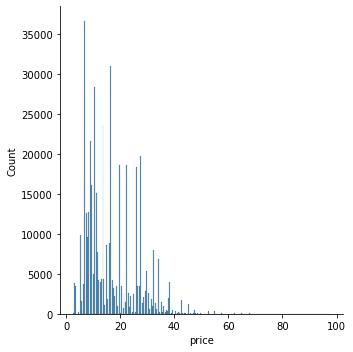

In [26]:
sns.displot(data = train, x = 'price', kind = 'hist')

In [23]:
new_train = train.copy()
new_train = new_train.drop(['price', 'id'], axis = 1)
new_train['log_distance'] = new_train['distance'].apply(lambda x: np.log(x))

In [24]:
new_test = test.copy()
new_test = new_test.drop(['price', 'id'], axis = 1)
new_test['log_distance'] = new_test['distance'].apply(lambda x: np.log(x))

2.1430671812361437

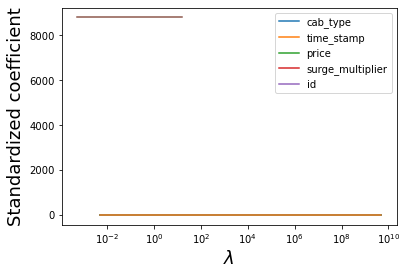

In [25]:
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import r2_score

#Taking the log transform of house_price as house prices have a right-skewed distribution
y = np.log(train.price)

#Standardizing predictors so that each of them have zero mean and unit variance

#Filtering all predictors
X = new_train; 

#Defining a scaler object
scaler = StandardScaler()

#The scaler object will contain the mean and variance of each column (predictor) of X. 
#These values will be useful to scale test data based on the same mean and variance as obtained on train data
scaler.fit(X)

#Using the scaler object (or the values of mean and variance stored in it) to standardize X (or train data)
Xstd = scaler.transform(X)

#The tuning parameter lambda is referred as alpha in sklearn

#Creating a range of values of the tuning parameter to visualize the ridge regression coefficients
#for different values of the tuning parameter
alphas = 10**np.linspace(10,-2,200)*0.5

#Finding the ridge regression coefficients for increasing values of the tuning parameter
coefs = []
for a in alphas:        
    ridge = Ridge(alpha = a)
    ridge.fit(Xstd, y)
    coefs.append(ridge.coef_)
    
#Visualizing the shrinkage in ridge regression coefficients with increasing values of the tuning parameter lambda
plt.xlabel('xlabel', fontsize=18)
plt.ylabel('ylabel', fontsize=18)
plt.plot(alphas, coefs)
plt.xscale('log')
plt.xlabel('$\lambda$')
plt.ylabel('Standardized coefficient')
plt.legend(train.columns[1:6]);

#Let us use cross validation to find the optimal value of the tuning parameter - lambda
#For the optimal lambda, the cross validation error will be the least

#Note that we are reducing the range of alpha so as to better visualize the minimum
alphas = 10**np.linspace(1.5,-3,200)*0.5
ridgecv = RidgeCV(alphas = alphas,store_cv_values=True)
ridgecv.fit(Xstd, y)

#Optimal value of the tuning parameter - lambda
ridgecv.alpha_

#Visualizing the LOOCV (leave one out cross validatation error vs lambda)
plt.xlabel('xlabel', fontsize=18)
plt.ylabel('ylabel', fontsize=18)
plt.plot(ridgecv.alphas,ridgecv.cv_values_.sum(axis=0))
plt.plot([ridgecv.alpha_,ridgecv.alpha_],[40,40.2],':')
plt.xlabel('$\lambda$')
plt.ylabel('Cross-validation error')

#Visualizing the shrinkage in ridge regression coefficients with increasing values of the tuning parameter lambda
alphas = 10**np.linspace(10,-2,200)*0.5
plt.xlabel('xlabel', fontsize=18)
plt.ylabel('ylabel', fontsize=18)
plt.plot(alphas, coefs)
plt.plot([ridgecv.alpha_,ridgecv.alpha_],[-0.4,0.2],':')
plt.xscale('log')
plt.xlabel('$\lambda$')
plt.ylabel('Standardized coefficient')
plt.legend(train.columns[1:6]);

#Test dataset
Xtest = new_test

#Standardizing test data
Xtest_std = scaler.transform(Xtest)

#Using the developed ridge regression model to predict on test data
ridge = Ridge(alpha = ridgecv.alpha_)
ridge.fit(Xstd, y)
pred=ridge.predict(Xtest_std)

#RMSE on test data
np.sqrt(((np.exp(pred)-test.price)**2).mean())

In [12]:
train.columns

Index(['distance', 'cab_type', 'time_stamp', 'price', 'surge_multiplier', 'id',
       'temp_source', 'clouds_source', 'pressure_source', 'rain_source',
       'humidity_source', 'wind_source', 'temp_destination',
       'clouds_destination', 'pressure_destination', 'rain_destination',
       'humidity_destination', 'wind_destination', 'desti_Back Bay',
       'desti_Beacon Hill', 'desti_Boston University', 'desti_Fenway',
       'desti_Financial District', 'desti_Haymarket Square', 'desti_North End',
       'desti_North Station', 'desti_Northeastern University',
       'desti_South Station', 'desti_Theatre District', 'desti_West End',
       'src_Back Bay', 'src_Beacon Hill', 'src_Boston University',
       'src_Fenway', 'src_Financial District', 'src_Haymarket Square',
       'src_North End', 'src_North Station', 'src_Northeastern University',
       'src_South Station', 'src_Theatre District', 'src_West End',
       'pid_55c66225-fbe7-4fd5-9072-eab1ece5e23e',
       'pid_6c84fd89-3f

In [101]:
ols_object = smf.ols(formula = 'price~'+'+'.join(train.columns), data = train)
model = ols_object.fit()
model.summary()

PatsyError: numbers besides '0' and '1' are only allowed with **
    price~distance+cab_type+time_stamp+price+surge_multiplier+id+temp_source+clouds_source+pressure_source+rain_source+humidity_source+wind_source+temp_destination+clouds_destination+pressure_destination+rain_destination+humidity_destination+wind_destination+desti_Back Bay+desti_Beacon Hill+desti_Boston University+desti_Fenway+desti_Financial District+desti_Haymarket Square+desti_North End+desti_North Station+desti_Northeastern University+desti_South Station+desti_Theatre District+desti_West End+src_Back Bay+src_Beacon Hill+src_Boston University+src_Fenway+src_Financial District+src_Haymarket Square+src_North End+src_North Station+src_Northeastern University+src_South Station+src_Theatre District+src_West End+pid_55c66225-fbe7-4fd5-9072-eab1ece5e23e+pid_6c84fd89-3f11-4782-9b50-97c468b19529+pid_6d318bcc-22a3-4af6-bddd-b409bfce1546+pid_6f72dfc5-27f1-42e8-84db-ccc7a75f6969+pid_997acbb5-e102-41e1-b155-9df7de0a73f2+pid_9a0e7b09-b92b-4c41-9779-2ad22b4d779d+pid_lyft+pid_lyft_line+pid_lyft_lux+pid_lyft_luxsuv+pid_lyft_plus+pid_lyft_premier+nm_Black+nm_Black SUV+nm_Lux+nm_Lux Black+nm_Lux Black XL+nm_Lyft+nm_Lyft XL+nm_Shared+nm_UberPool+nm_UberX+nm_UberXL+nm_WAV
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      ^^^^

In [16]:
train_reset = train.reset_index()
ols_object = smf.ols(formula = 'price~distance+surge_multiplier+time_stamp+temp_source+cab_type+rain_source', data = train)
model=ols_object.fit()

In [17]:
#take a look at high leverage points
influence = model.get_influence()
leverage = influence.hat_matrix_diag
#obtain standardized residuals
standardized_residuals = influence.resid_studentized_internal
#create high leverage threshold
average_leverage = (model.df_model+1)/model.nobs
high_leverage_threshold = 4*average_leverage
np.sum(leverage>high_leverage_threshold)

8362

In [19]:
#remove high leverage
train_filt = train_reset.drop(np.intersect1d(np.where(np.abs(standardized_residuals)>3)[0],
                                           (np.where(leverage>high_leverage_threshold)[0])))

In [28]:
train_filt.drop("index", axis = "columns", inplace = True),
train_filt.head()

,distance,cab_type,time_stamp,price,surge_multiplier,id,temp_source,clouds_source,pressure_source,rain_source,...,nm_Lux,nm_Lux Black,nm_Lux Black XL,nm_Lyft,nm_Lyft XL,nm_Shared,nm_UberPool,nm_UberX,nm_UberXL,nm_WAV
0,2.94,0,1543751583656,7.0,1.0,b5e6626f-a173-4106-91c7-ba0a9ef00adc,38.983403,0.677247,1008.441090,0.008657,...,0,0,0,0,0,1,0,0,0,0
1,0.72,0,1545115805704,3.0,1.0,bc9d37c4-b0bf-4a68-a277-e944f78fde68,39.035315,0.676998,1008.442811,0.008649,...,0,0,0,0,0,1,0,0,0,0
2,3.29,0,1545023403567,26.0,1.0,d658a158-b38e-48cc-9cb1-4d104f32cce3,39.035315,0.676998,1008.442811,0.008649,...,0,1,0,0,0,0,0,0,0,0
3,2.29,0,1544979305874,22.5,1.0,6480a56e-2969-4996-9e99-32c05c8116cf,39.067897,0.676711,1008.445239,0.008660,...,0,1,0,0,0,0,0,0,0,0
4,1.61,1,1543423628184,12.5,1.0,df5ebfea-45e1-4030-97a8-251c6ad01427,38.986711,0.677763,1008.444742,0.008405,...,0,0,0,0,0,0,0,0,1,0


In [29]:
new_train2 = train_filt.copy()
new_train2 = new_train2.drop(['price', 'id'], axis = 1)
new_train2['log_distance'] = new_train2['distance'].apply(lambda x: np.log(x))

/Users/keatonolds/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:1791: RuntimeWarning: invalid value encountered in reciprocal
  w = ((singvals_sq + alpha) ** -1) - (alpha ** -1)


2.1433112027773653

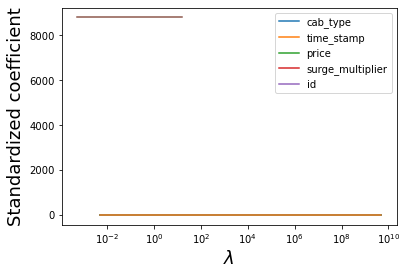

In [30]:
#SAME THING AS ABOVE BUT WITHOUT INFLUENTIAL POINTS

#Taking the log transform of house_price as house prices have a right-skewed distribution
y = np.log(train_filt.price)

#Standardizing predictors so that each of them have zero mean and unit variance

#Filtering all predictors
X = new_train2; 

#Defining a scaler object
scaler = StandardScaler()

#The scaler object will contain the mean and variance of each column (predictor) of X. 
#These values will be useful to scale test data based on the same mean and variance as obtained on train data
scaler.fit(X)

#Using the scaler object (or the values of mean and variance stored in it) to standardize X (or train data)
Xstd = scaler.transform(X)

#The tuning parameter lambda is referred as alpha in sklearn

#Creating a range of values of the tuning parameter to visualize the ridge regression coefficients
#for different values of the tuning parameter
alphas = 10**np.linspace(10,-2,200)*0.5

#Finding the ridge regression coefficients for increasing values of the tuning parameter
coefs = []
for a in alphas:        
    ridge = Ridge(alpha = a)
    ridge.fit(Xstd, y)
    coefs.append(ridge.coef_)
    
#Visualizing the shrinkage in ridge regression coefficients with increasing values of the tuning parameter lambda
plt.xlabel('xlabel', fontsize=18)
plt.ylabel('ylabel', fontsize=18)
plt.plot(alphas, coefs)
plt.xscale('log')
plt.xlabel('$\lambda$')
plt.ylabel('Standardized coefficient')
plt.legend(train.columns[1:6]);

#Let us use cross validation to find the optimal value of the tuning parameter - lambda
#For the optimal lambda, the cross validation error will be the least

#Note that we are reducing the range of alpha so as to better visualize the minimum
alphas = 10**np.linspace(1.5,-3,200)*0.5
ridgecv = RidgeCV(alphas = alphas,store_cv_values=True)
ridgecv.fit(Xstd, y)

#Optimal value of the tuning parameter - lambda
ridgecv.alpha_

#Visualizing the LOOCV (leave one out cross validatation error vs lambda)
plt.xlabel('xlabel', fontsize=18)
plt.ylabel('ylabel', fontsize=18)
plt.plot(ridgecv.alphas,ridgecv.cv_values_.sum(axis=0))
plt.plot([ridgecv.alpha_,ridgecv.alpha_],[40,40.2],':')
plt.xlabel('$\lambda$')
plt.ylabel('Cross-validation error')

#Visualizing the shrinkage in ridge regression coefficients with increasing values of the tuning parameter lambda
alphas = 10**np.linspace(10,-2,200)*0.5
plt.xlabel('xlabel', fontsize=18)
plt.ylabel('ylabel', fontsize=18)
plt.plot(alphas, coefs)
plt.plot([ridgecv.alpha_,ridgecv.alpha_],[-0.4,0.2],':')
plt.xscale('log')
plt.xlabel('$\lambda$')
plt.ylabel('Standardized coefficient')
plt.legend(train.columns[1:6]);

#Test dataset
Xtest = new_test

#Standardizing test data
Xtest_std = scaler.transform(Xtest)

#Using the developed ridge regression model to predict on test data
ridge = Ridge(alpha = ridgecv.alpha_)
ridge.fit(Xstd, y)
pred=ridge.predict(Xtest_std)

#RMSE on test data
np.sqrt(((np.exp(pred)-test.price)**2).mean())

2.141934130760698

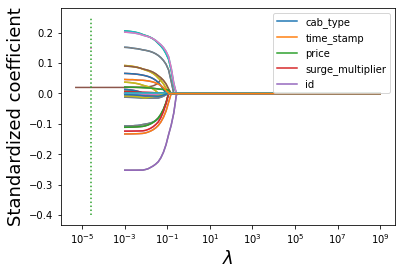

In [92]:
#Creating a range of values of the tuning parameter to visualize the lasso coefficients
#for different values of the tuning parameter
alphas = 10**np.linspace(10,-2,100)*0.1

#Finding the lasso coefficients for increasing values of the tuning parameter
lasso = Lasso(max_iter = 10000)
coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(Xstd, y)
    coefs.append(lasso.coef_)
    
#Visualizing the shrinkage in lasso coefficients with increasing values of the tuning parameter lambda
plt.xlabel('xlabel', fontsize=18)
plt.ylabel('ylabel', fontsize=18)
plt.plot(alphas, coefs)
plt.xscale('log')
plt.xlabel('$\lambda$')
plt.ylabel('Standardized coefficient')
plt.legend(train.columns[1:6]);
#plt.plot([lassocv.alpha_,lassocv.alpha_],[-0.4,0.25],':')
plt.legend(train.columns[1:6]);

#Let us use cross validation to find the optimal value of the tuning parameter - lambda
#For the optimal lambda, the cross validation error will be the least

#Note that we are reducing the range of alpha so as to better visualize the minimum
alphas = 10**np.linspace(-1,-5,200)*0.5
lassocv = LassoCV(alphas = alphas, cv = 10, max_iter = 100000)
lassocv.fit(Xstd, y)

#Optimal value of the tuning parameter - lamda
lassocv.alpha_

#Visualizing the LOOCV (leave one out cross validatation error vs lambda)
plt.xlabel('xlabel', fontsize=18)
plt.ylabel('ylabel', fontsize=18)
plt.plot(lassocv.alphas_,lassocv.mse_path_.mean(axis=1))
plt.plot([lassocv.alpha_,lassocv.alpha_],[0.145,0.151],':')
plt.xlabel('$\lambda$')
plt.ylabel('Cross-validation error')

#Visualizing the shrinkage in lasso coefficients with increasing values of the tuning parameter lambda
alphas = 10**np.linspace(10,-2,100)*0.1
plt.xlabel('xlabel', fontsize=18)
plt.ylabel('ylabel', fontsize=18)
plt.plot(alphas, coefs)
plt.xscale('log')
plt.xlabel('$\lambda$')
plt.ylabel('Standardized coefficient')
plt.legend(train.columns[1:6]);
plt.plot([lassocv.alpha_,lassocv.alpha_],[-0.4,0.25],':')
plt.legend(train.columns[1:6]);

#Using the developed lasso model to predict on test data
lasso = Lasso(alpha = lassocv.alpha_)
lasso.fit(Xstd, y)
pred=lasso.predict(Xtest_std)

#RMSE on test data
np.sqrt(((np.exp(pred)-test.price)**2).mean())

/Users/keatonolds/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.582e+02, tolerance: 1.435e+01
  model = cd_fast.enet_coordinate_descent(


2.143246531396371

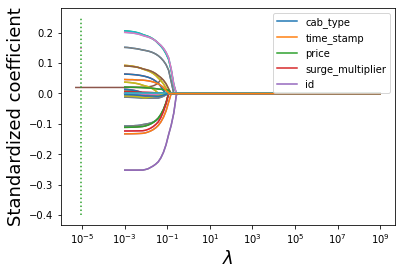

In [31]:
#SAME THING BUT REMOVED INFLUENTIALS

#Creating a range of values of the tuning parameter to visualize the lasso coefficients
#for different values of the tuning parameter
alphas = 10**np.linspace(10,-2,100)*0.1

#Finding the lasso coefficients for increasing values of the tuning parameter
lasso = Lasso(max_iter = 10000)
coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(Xstd, y)
    coefs.append(lasso.coef_)
    
#Visualizing the shrinkage in lasso coefficients with increasing values of the tuning parameter lambda
plt.xlabel('xlabel', fontsize=18)
plt.ylabel('ylabel', fontsize=18)
plt.plot(alphas, coefs)
plt.xscale('log')
plt.xlabel('$\lambda$')
plt.ylabel('Standardized coefficient')
plt.legend(train.columns[1:6]);
#plt.plot([lassocv.alpha_,lassocv.alpha_],[-0.4,0.25],':')
plt.legend(train.columns[1:6]);

#Let us use cross validation to find the optimal value of the tuning parameter - lambda
#For the optimal lambda, the cross validation error will be the least

#Note that we are reducing the range of alpha so as to better visualize the minimum
alphas = 10**np.linspace(-1,-5,200)*0.5
lassocv = LassoCV(alphas = alphas, cv = 10, max_iter = 100000)
lassocv.fit(Xstd, y)

#Optimal value of the tuning parameter - lamda
lassocv.alpha_

#Visualizing the LOOCV (leave one out cross validatation error vs lambda)
plt.xlabel('xlabel', fontsize=18)
plt.ylabel('ylabel', fontsize=18)
plt.plot(lassocv.alphas_,lassocv.mse_path_.mean(axis=1))
plt.plot([lassocv.alpha_,lassocv.alpha_],[0.145,0.151],':')
plt.xlabel('$\lambda$')
plt.ylabel('Cross-validation error')

#Visualizing the shrinkage in lasso coefficients with increasing values of the tuning parameter lambda
alphas = 10**np.linspace(10,-2,100)*0.1
plt.xlabel('xlabel', fontsize=18)
plt.ylabel('ylabel', fontsize=18)
plt.plot(alphas, coefs)
plt.xscale('log')
plt.xlabel('$\lambda$')
plt.ylabel('Standardized coefficient')
plt.legend(train.columns[1:6]);
plt.plot([lassocv.alpha_,lassocv.alpha_],[-0.4,0.25],':')
plt.legend(train.columns[1:6]);

#Using the developed lasso model to predict on test data
lasso = Lasso(alpha = lassocv.alpha_)
lasso.fit(Xstd, y)
pred=lasso.predict(Xtest_std)

#RMSE on test data
np.sqrt(((np.exp(pred)-test.price)**2).mean())

In [3]:
train = pd.read_csv('train_final_best_2.csv')
test = pd.read_csv('test_final_best_2.csv')
train.head()

,Unnamed: 0,distance,cab_type,destination,source,price,surge_multiplier,id,product_id,name,time_ride,date_hour,temp,location,clouds,pressure,rain,humidity,wind,time_weather
0,643,0.63,Lyft,Financial District,South Station,26.0,1.0,4a180790-b8cf-46a4-a144-c0263c5a2472,lyft_luxsuv,Lux Black XL,2018-11-28 16:06:22.934,2018-11-28:16.06.22,41.17,South Station,0.63,991.57,0.000,0.62,10.01,2018-11-28 16:06:22.000
1,1675,0.56,Uber,Haymarket Square,North Station,27.5,1.0,8fad149e-8fa2-45d0-b521-c1d9ba530d29,6d318bcc-22a3-4af6-bddd-b409bfce1546,Black SUV,2018-11-29 02:07:18.274,2018-11-29:02.07.18,38.35,North Station,0.50,997.89,0.002,0.70,10.38,2018-11-29 02:07:18.000
2,1389,2.85,Uber,Beacon Hill,Haymarket Square,31.0,1.0,04c07c57-a71e-4103-9c87-9816765d68a0,6d318bcc-22a3-4af6-bddd-b409bfce1546,Black SUV,2018-11-28 16:02:08.213,2018-11-28:16.02.08,41.22,Haymarket Square,0.63,991.56,0.000,0.62,9.89,2018-11-28 16:02:08.000
3,2201,1.84,Uber,North Station,South Station,27.0,1.0,0bbbd244-05e1-443b-9443-4b875140f8f0,6d318bcc-22a3-4af6-bddd-b409bfce1546,Black SUV,2018-12-01 02:53:00.951,2018-12-01:02.53.00,36.40,South Station,0.90,1018.82,0.000,0.70,3.77,2018-12-01 02:53:00.000
4,1036,1.73,Lyft,Haymarket Square,Theatre District,22.5,1.0,e65ac260-22c2-4691-9b01-f46a1dd816ec,lyft_lux,Lux Black,2018-11-28 10:02:08.053,2018-11-28:10.02.08,33.10,Theatre District,0.13,991.18,0.000,0.84,5.59,2018-11-28 10:02:08.000


In [15]:
from datetime import datetime

In [16]:
train['timestamp'] = train.date_hour.apply(lambda x: (datetime.strptime(x,'%Y-%m-%d:%H.%M.%S')))
test['timestamp'] = test.date_hour.apply(lambda x: (datetime.strptime(x,'%Y-%m-%d:%H.%M.%S')))

#Find hour of each trip
train['hour'] = train['timestamp'].dt.strftime('%H')
test['hour'] = test['timestamp'].dt.strftime('%H')

#Find date of each trip
train['date'] = train['timestamp'].dt.strftime('%Y-%m-%d') 
test['date'] = test['timestamp'].dt.strftime('%Y-%m-%d') 

#Find day name of each trip
train['day'] = train['timestamp'].dt.day_name()
test['day'] = test['timestamp'].dt.day_name()

# drop redundant fields 
train = train.drop('timestamp', axis=1)
test = test.drop('timestamp', axis=1)

In [17]:
train['hour']=train['hour'].astype('int')

In [18]:
train.head()

,Unnamed: 0,distance,cab_type,destination,source,price,surge_multiplier,id,product_id,name,...,location,clouds,pressure,rain,humidity,wind,time_weather,hour,date,day
0,643,0.63,Lyft,Financial District,South Station,26.0,1.0,4a180790-b8cf-46a4-a144-c0263c5a2472,lyft_luxsuv,Lux Black XL,...,South Station,0.63,991.57,0.000,0.62,10.01,2018-11-28 16:06:22.000,16,2018-11-28,Wednesday
1,1675,0.56,Uber,Haymarket Square,North Station,27.5,1.0,8fad149e-8fa2-45d0-b521-c1d9ba530d29,6d318bcc-22a3-4af6-bddd-b409bfce1546,Black SUV,...,North Station,0.50,997.89,0.002,0.70,10.38,2018-11-29 02:07:18.000,2,2018-11-29,Thursday
2,1389,2.85,Uber,Beacon Hill,Haymarket Square,31.0,1.0,04c07c57-a71e-4103-9c87-9816765d68a0,6d318bcc-22a3-4af6-bddd-b409bfce1546,Black SUV,...,Haymarket Square,0.63,991.56,0.000,0.62,9.89,2018-11-28 16:02:08.000,16,2018-11-28,Wednesday
3,2201,1.84,Uber,North Station,South Station,27.0,1.0,0bbbd244-05e1-443b-9443-4b875140f8f0,6d318bcc-22a3-4af6-bddd-b409bfce1546,Black SUV,...,South Station,0.90,1018.82,0.000,0.70,3.77,2018-12-01 02:53:00.000,2,2018-12-01,Saturday
4,1036,1.73,Lyft,Haymarket Square,Theatre District,22.5,1.0,e65ac260-22c2-4691-9b01-f46a1dd816ec,lyft_lux,Lux Black,...,Theatre District,0.13,991.18,0.000,0.84,5.59,2018-11-28 10:02:08.000,10,2018-11-28,Wednesday


In [19]:
train.shape

(2483, 23)

In [20]:
mlr_model_initial = smf.ols(formula = 'price~distance+cab_type+destination+source+product_id+name', data = train).fit()
np.sqrt(((test.price - mlr_model_initial.predict(test))**2).mean())

3.6270205260516555

In [21]:
out = mlr_model_initial.outlier_test()

/Users/keatonolds/opt/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py:2158: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)


In [22]:
np.sum((np.abs(out.student_resid)>3))

25

In [23]:
25/2483

0.010068465565847765

In [24]:
influence = mlr_model_initial.get_influence()
leverage = influence.hat_matrix_diag
average_leverage = (mlr_model_initial.df_model+1)/mlr_model_initial.nobs

In [25]:
high_leverage_threshold = 4*average_leverage
np.sum(leverage>high_leverage_threshold)

0

In [ ]:
res=build_model(['temp_hot', 'temp_cold'])